In [105]:
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")

In [143]:
######################
# Statewide analysis #
######################
# Covid deaths are overcounted by about 80k in 2021. Not as much as expected, but this means that we can't use 
# non-covid death counts as a response to vaccine deaths, i.e. we would get negative deaths predicted.
# A few other things things to note
# 1. Each state has a different deviation from pre-2020 non-flu deaths -> different diagnoses statewide
# 2. There is a discrete jump up in covid deaths Jan 2020, and a corresponding jump down in non-flu deaths

# Also, we show
# 1. Raw statewide death counts as a fraction of total
# 2. Normalized statewide death counts
# 3. Relative contribution from each state
# California	0.12407822
# `New York City`	0.11347172
# Florida	0.06615664
# Texas	0.06427249
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]

# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_old$State = us_death_old$Jurisdiction.of.Occurrence
us_death_old$flu_like_deaths = us_death_old$Influenza.and.pneumonia..J10.J18.

us_death$flu_like_deaths = us_death$Pneumonia..Influenza..or.COVID.19.Deaths
colnames(us_death)
colnames(us_death_old)
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "flu_like_deaths", "data_set", "MMWR.Week", "State")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "flu_like_deaths", "data_set", "MMWR.Week", "State")])
us_death_all$days = us_death_all$Week.Ending.Date - us_death_all$Week.Ending.Date[1]

[1] "Data.as.of"                              
 [2] "Start.Date"                              
 [3] "End.Date"                                
 [4] "Group"                                   
 [5] "Year"                                    
 [6] "Month"                                   
 [7] "MMWR.Week"                               
 [8] "Week.Ending.Date"                        
 [9] "State"                                   
[10] "COVID.19.Deaths"                         
[11] "Total.Deaths"                            
[12] "Percent.of.Expected.Deaths"              
[13] "Pneumonia.Deaths"                        
[14] "Pneumonia.and.COVID.19.Deaths"           
[15] "Influenza.Deaths"                        
[16] "Pneumonia..Influenza..or.COVID.19.Deaths"
[17] "Footnote"                                
[18] "data_set"                                
[19] "flu_like_deaths"

[1] "Jurisdiction.of.Occurrence"                                                                       
 [2] "MMWR.Year"                                                                                        
 [3] "MMWR.Week"                                                                                        
 [4] "Week.Ending.Date"                                                                                 
 [5] "All..Cause"                                                                                       
 [6] "Natural.Cause"                                                                                    
 [7] "Septicemia..A40.A41."                                                                             
 [8] "Malignant.neoplasms..C00.C97."                                                                    
 [9] "Diabetes.mellitus..E10.E14."                                                                      
[10] "Alzheimer.disease..G30."                                                                          
[11] "Influenza.and.pneumonia..J10.J18."                                                                
[12] "Chronic.lower.respiratory.diseases..J40.J47."                                                     
[13] "Other.diseases.of.respiratory.system..J00.J06.J30.J39.J67.J70.J98."                               
[14] "Nephritis..nephrotic.syndrome.and.nephrosis..N00.N07.N17.N19.N25.N27."                            
[15] "Symptoms..signs.and.abnormal.clinical.and.laboratory.findings..not.elsewhere.classified..R00.R99."
[16] "Diseases.of.heart..I00.I09.I11.I13.I20.I51."                                                      
[17] "Cerebrovascular.diseases..I60.I69."                                                               
[18] "flag_allcause"                                                                                    
[19] "flag_natcause"                                                                                    
[20] "flag_sept"                                                                                        
[21] "flag_neopl"                                                                                       
[22] "flag_diab"                                                                                        
[23] "flag_alz"                                                                                         
[24] "flag_inflpn"                                                                                      
[25] "flag_clrd"                                                                                        
[26] "flag_otherresp"                                                                                   
[27] "flag_nephr"                                                                                       
[28] "flag_otherunk"                                                                                    
[29] "flag_hd"                                                                                          
[30] "flag_stroke"                                                                                      
[31] "Total.Deaths"                                                                                     
[32] "data_set"                                                                                         
[33] "State"                                                                                            
[34] "flu_like_deaths"

In [144]:
detrend = function(times, values, dates) {
    idx = year(dates) < 2020
    rq.fit = rq(values[idx] ~ times[idx])
    detrended = as.numeric(values - times * rq.fit$coef[2])
    detrended
}

In [145]:
state_centered = us_death_all %>% group_by(State) %>% summarize(
    flu_like_deaths=flu_like_deaths,
    detrended = detrend(days, Total.Deaths, Week.Ending.Date),
    detrended_flu_like = detrend(days, flu_like_deaths, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week,
    State = State)
head(state_centered)

`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.



State,flu_like_deaths,detrended,detrended_flu_like,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week
<chr>,<int>,<dbl>,<dbl>,<date>,<int>,<chr>,<int>
Alabama,38,1057.0000,38,2014-01-04,1057,2014-2019,1
Alabama,37,1076.7215,37,2014-01-11,1077,2014-2019,2
Alabama,34,1047.4430,34,2014-01-18,1048,2014-2019,3
Alabama,42,1021.1646,42,2014-01-25,1022,2014-2019,4
Alabama,26,1039.8861,26,2014-02-01,1041,2014-2019,5
Alabama,31,990.6076,31,2014-02-08,992,2014-2019,6


In [146]:
find_median = function(weeks, values, dates) {
    idx = year(dates) < 2020
    state_deaths = data.frame(weeks=weeks, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values, na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}

In [147]:
state_centered = state_centered %>% group_by(State) %>% summarize(
    flu_like_deaths=flu_like_deaths,
    detrended = detrended,
    detrended_flu_like = detrended_flu_like,
    median = find_median(MMWR.Week, detrended, Week.Ending.Date),
    median_flu_like = find_median(MMWR.Week, detrended_flu_like, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week)
state_centered$centered = state_centered$detrended - state_centered$median
state_centered$centered_flu_like = state_centered$detrended_flu_like - state_centered$median_flu_like
state_centered$non_flu_deaths = state_centered$Total.Deaths - state_centered$flu_like_deaths
state_centered$detrended_non_flu_like = state_centered$detrended - state_centered$detrended_flu_like
state_centered$centered_non_flu_like = state_centered$centered - state_centered$centered_flu_like

`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.



In [148]:
sum_deaths = (state_centered %>% group_by(State) %>% summarize(sum=sum(Total.Deaths)))
sum_deaths = sum_deaths[order(sum_deaths$sum), ]
largest_ten = tail(sum_deaths, 10)$State

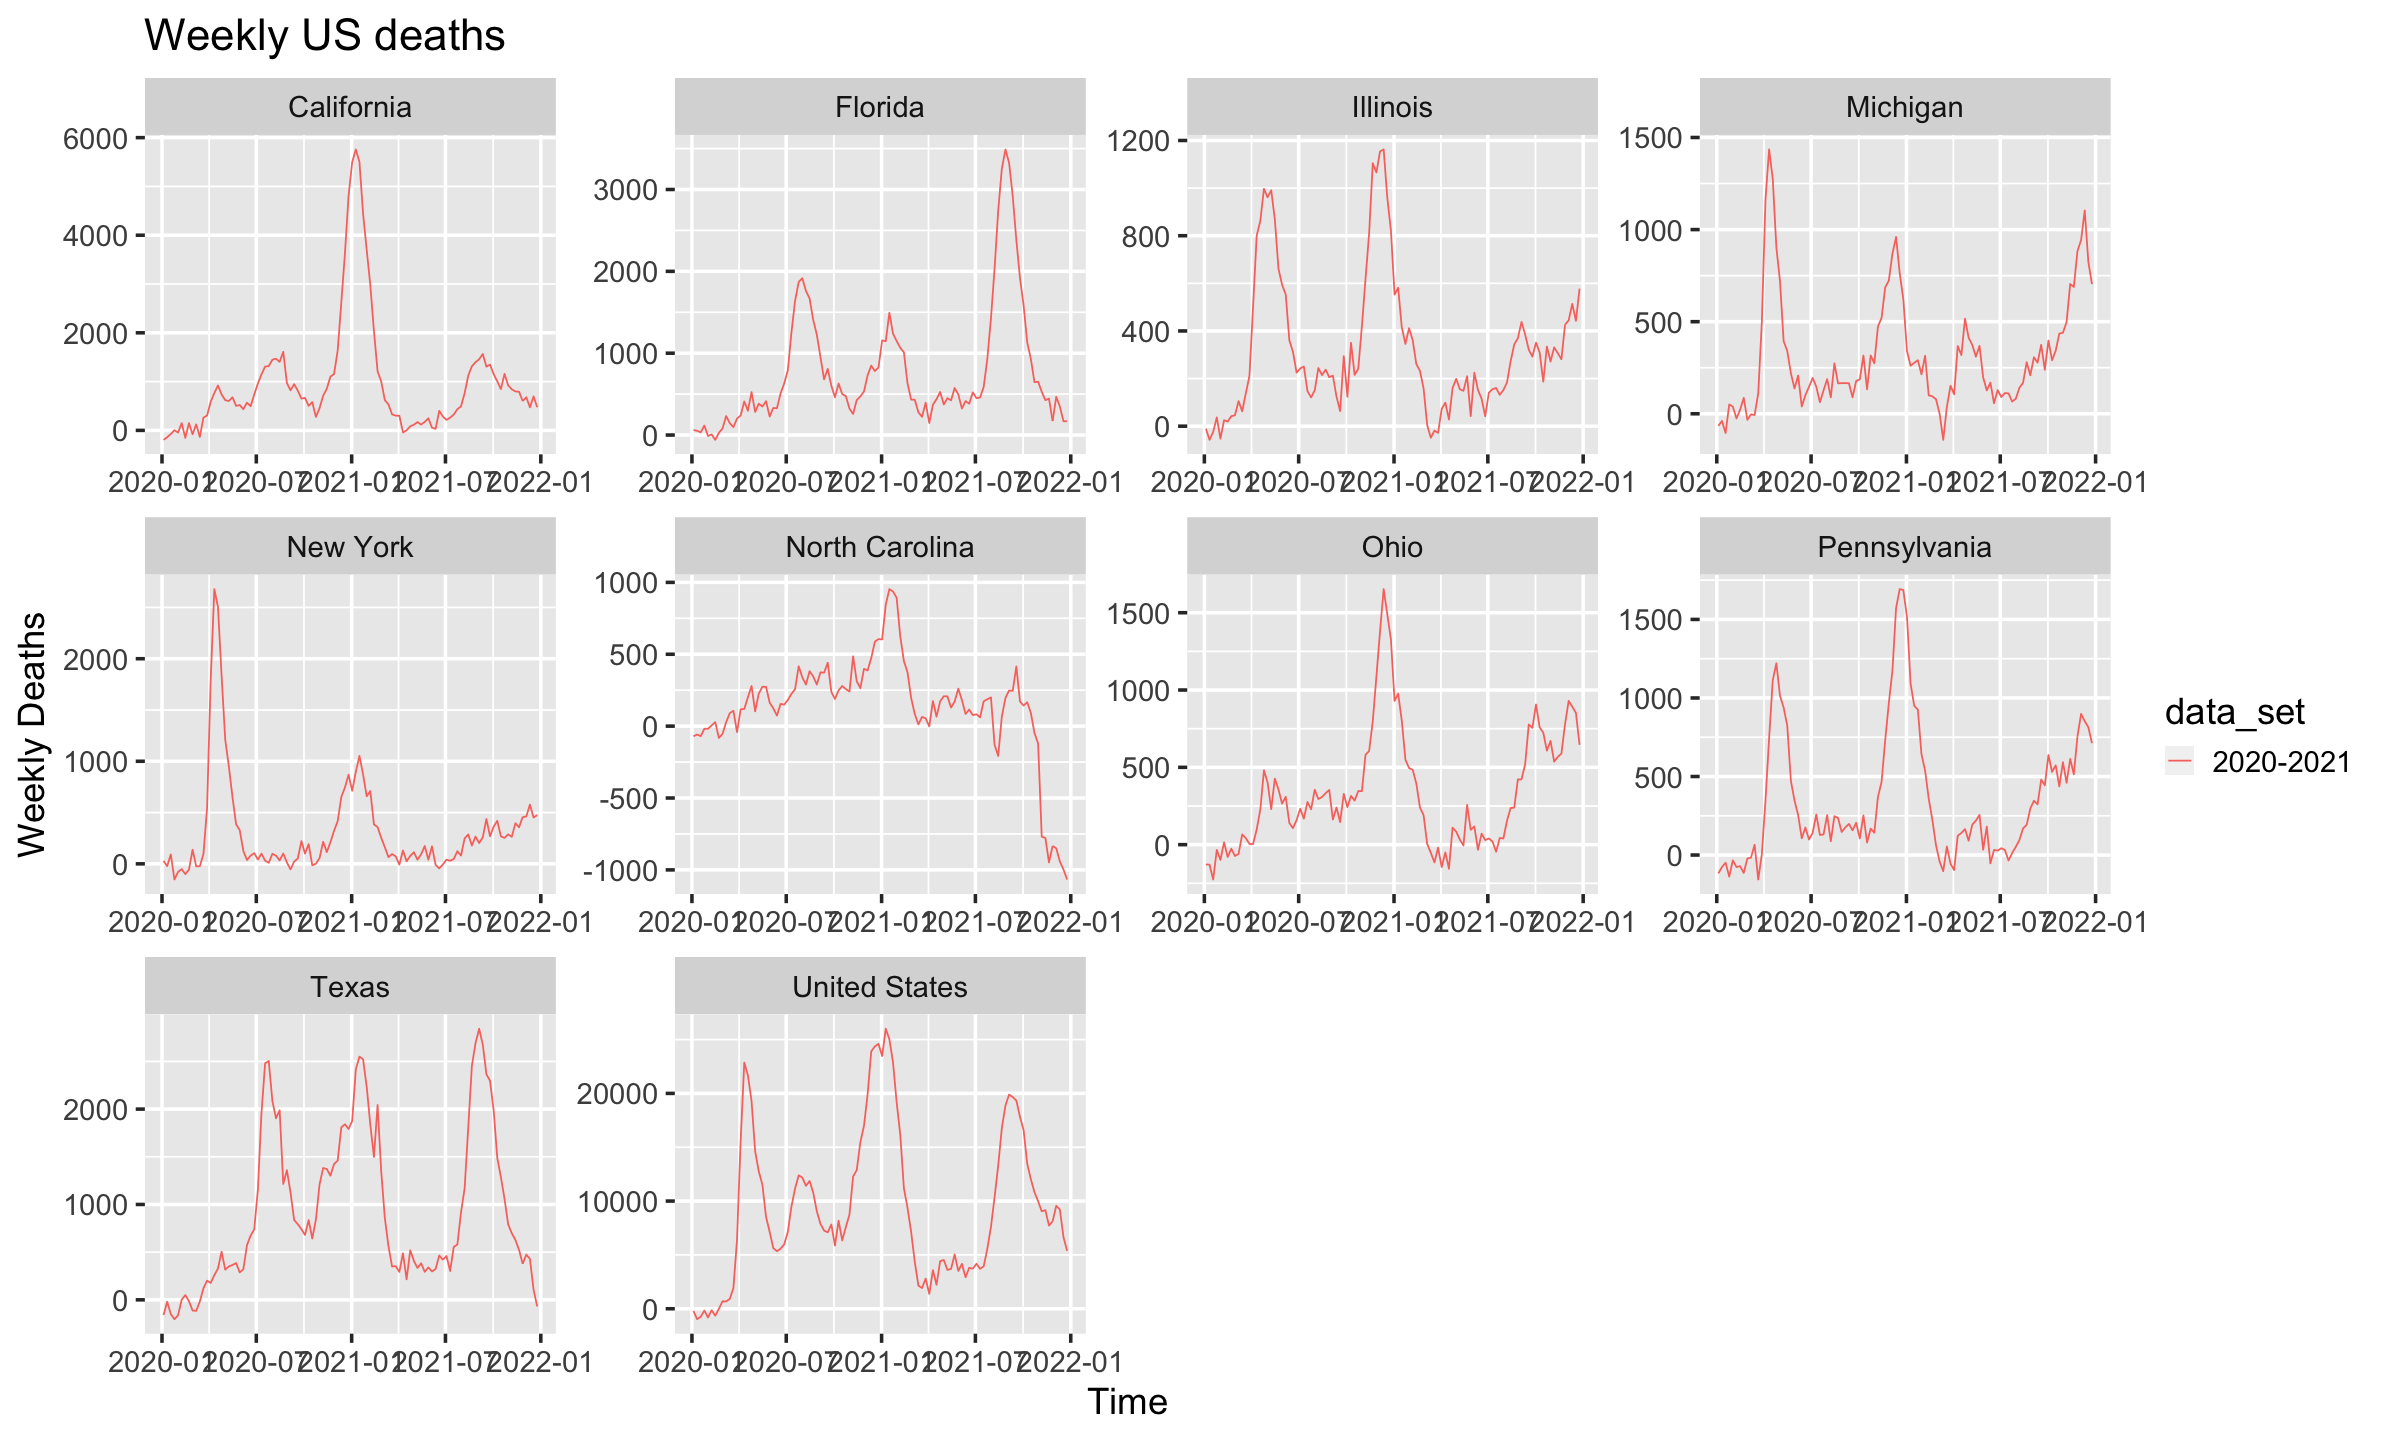

In [149]:
# Plot with quantile trend from 2014-2019
options(repr.plot.width=20, repr.plot.height=12)
b = ggplot(state_centered[state_centered$State %in% largest_ten & year(state_centered$Week.Ending.Date) > 2019,], 
           aes(x=Week.Ending.Date, y=detrended - median, color=data_set))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [150]:
write.csv(state_centered, "../data/state_centered.csv")

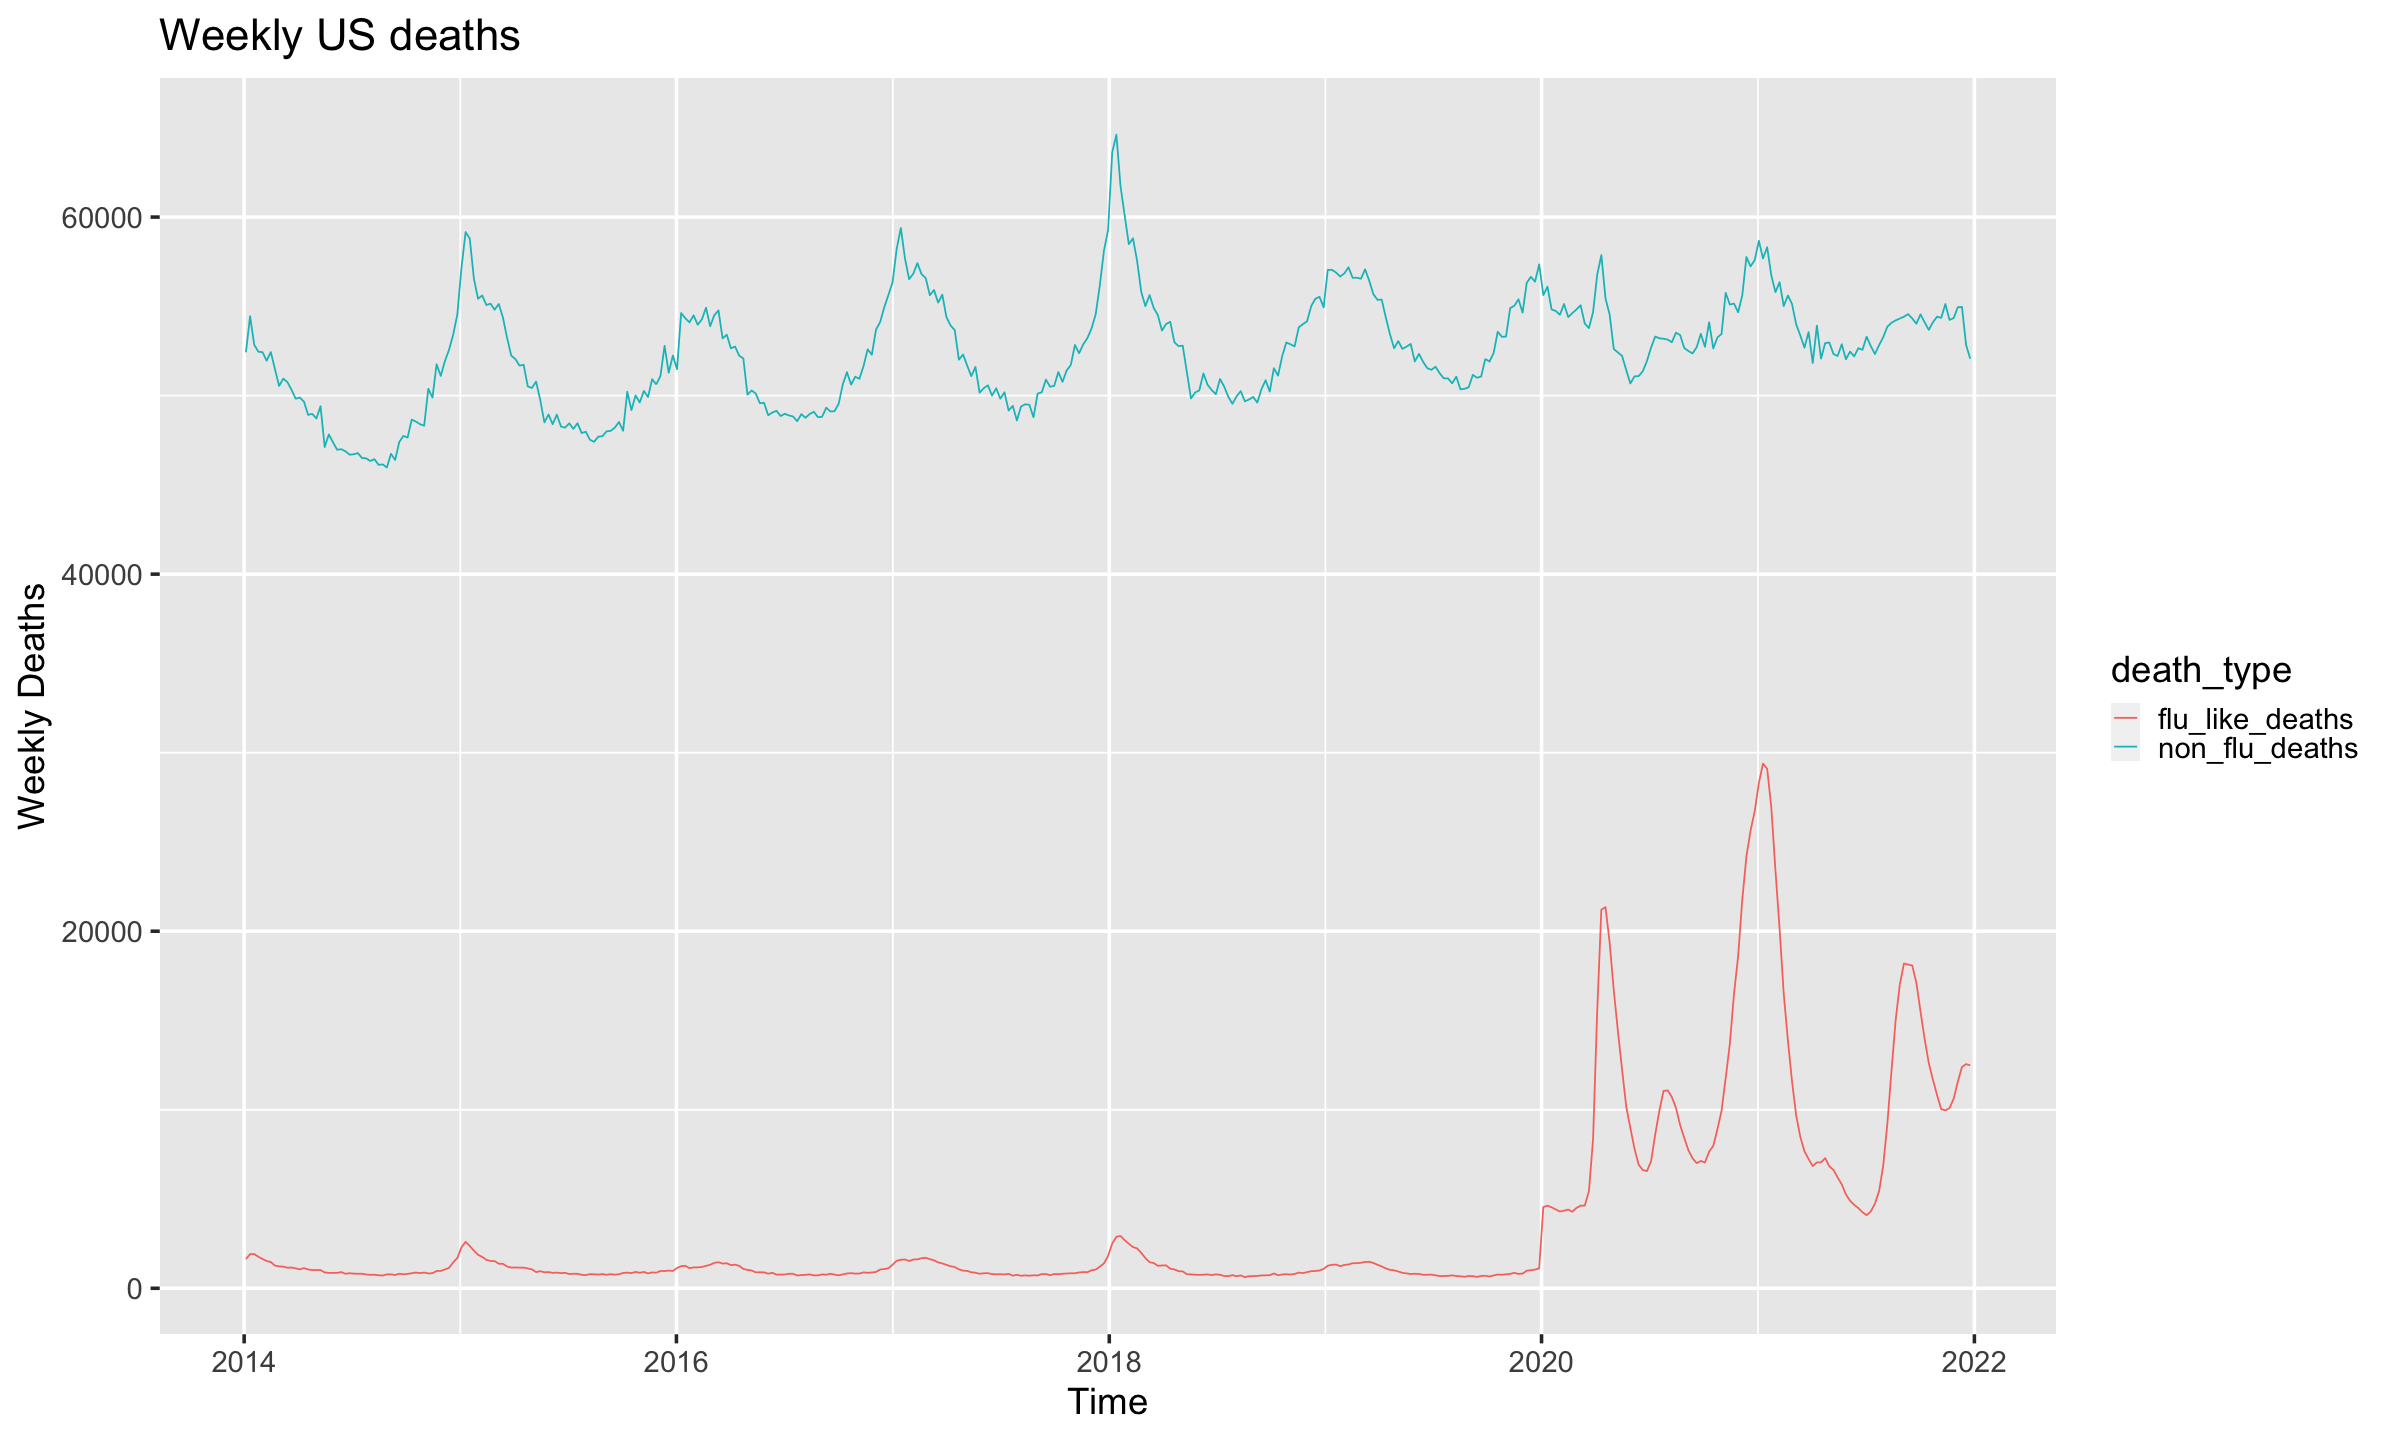

In [153]:
# Plot with quantile trend from 2014-2019
pivoted = pivot_longer(state_centered, cols = c("non_flu_deaths", "flu_like_deaths"), values_to="deaths", names_to="death_type")
options(repr.plot.width=20, repr.plot.height=12)
b = ggplot(pivoted[pivoted$State == "United States",], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

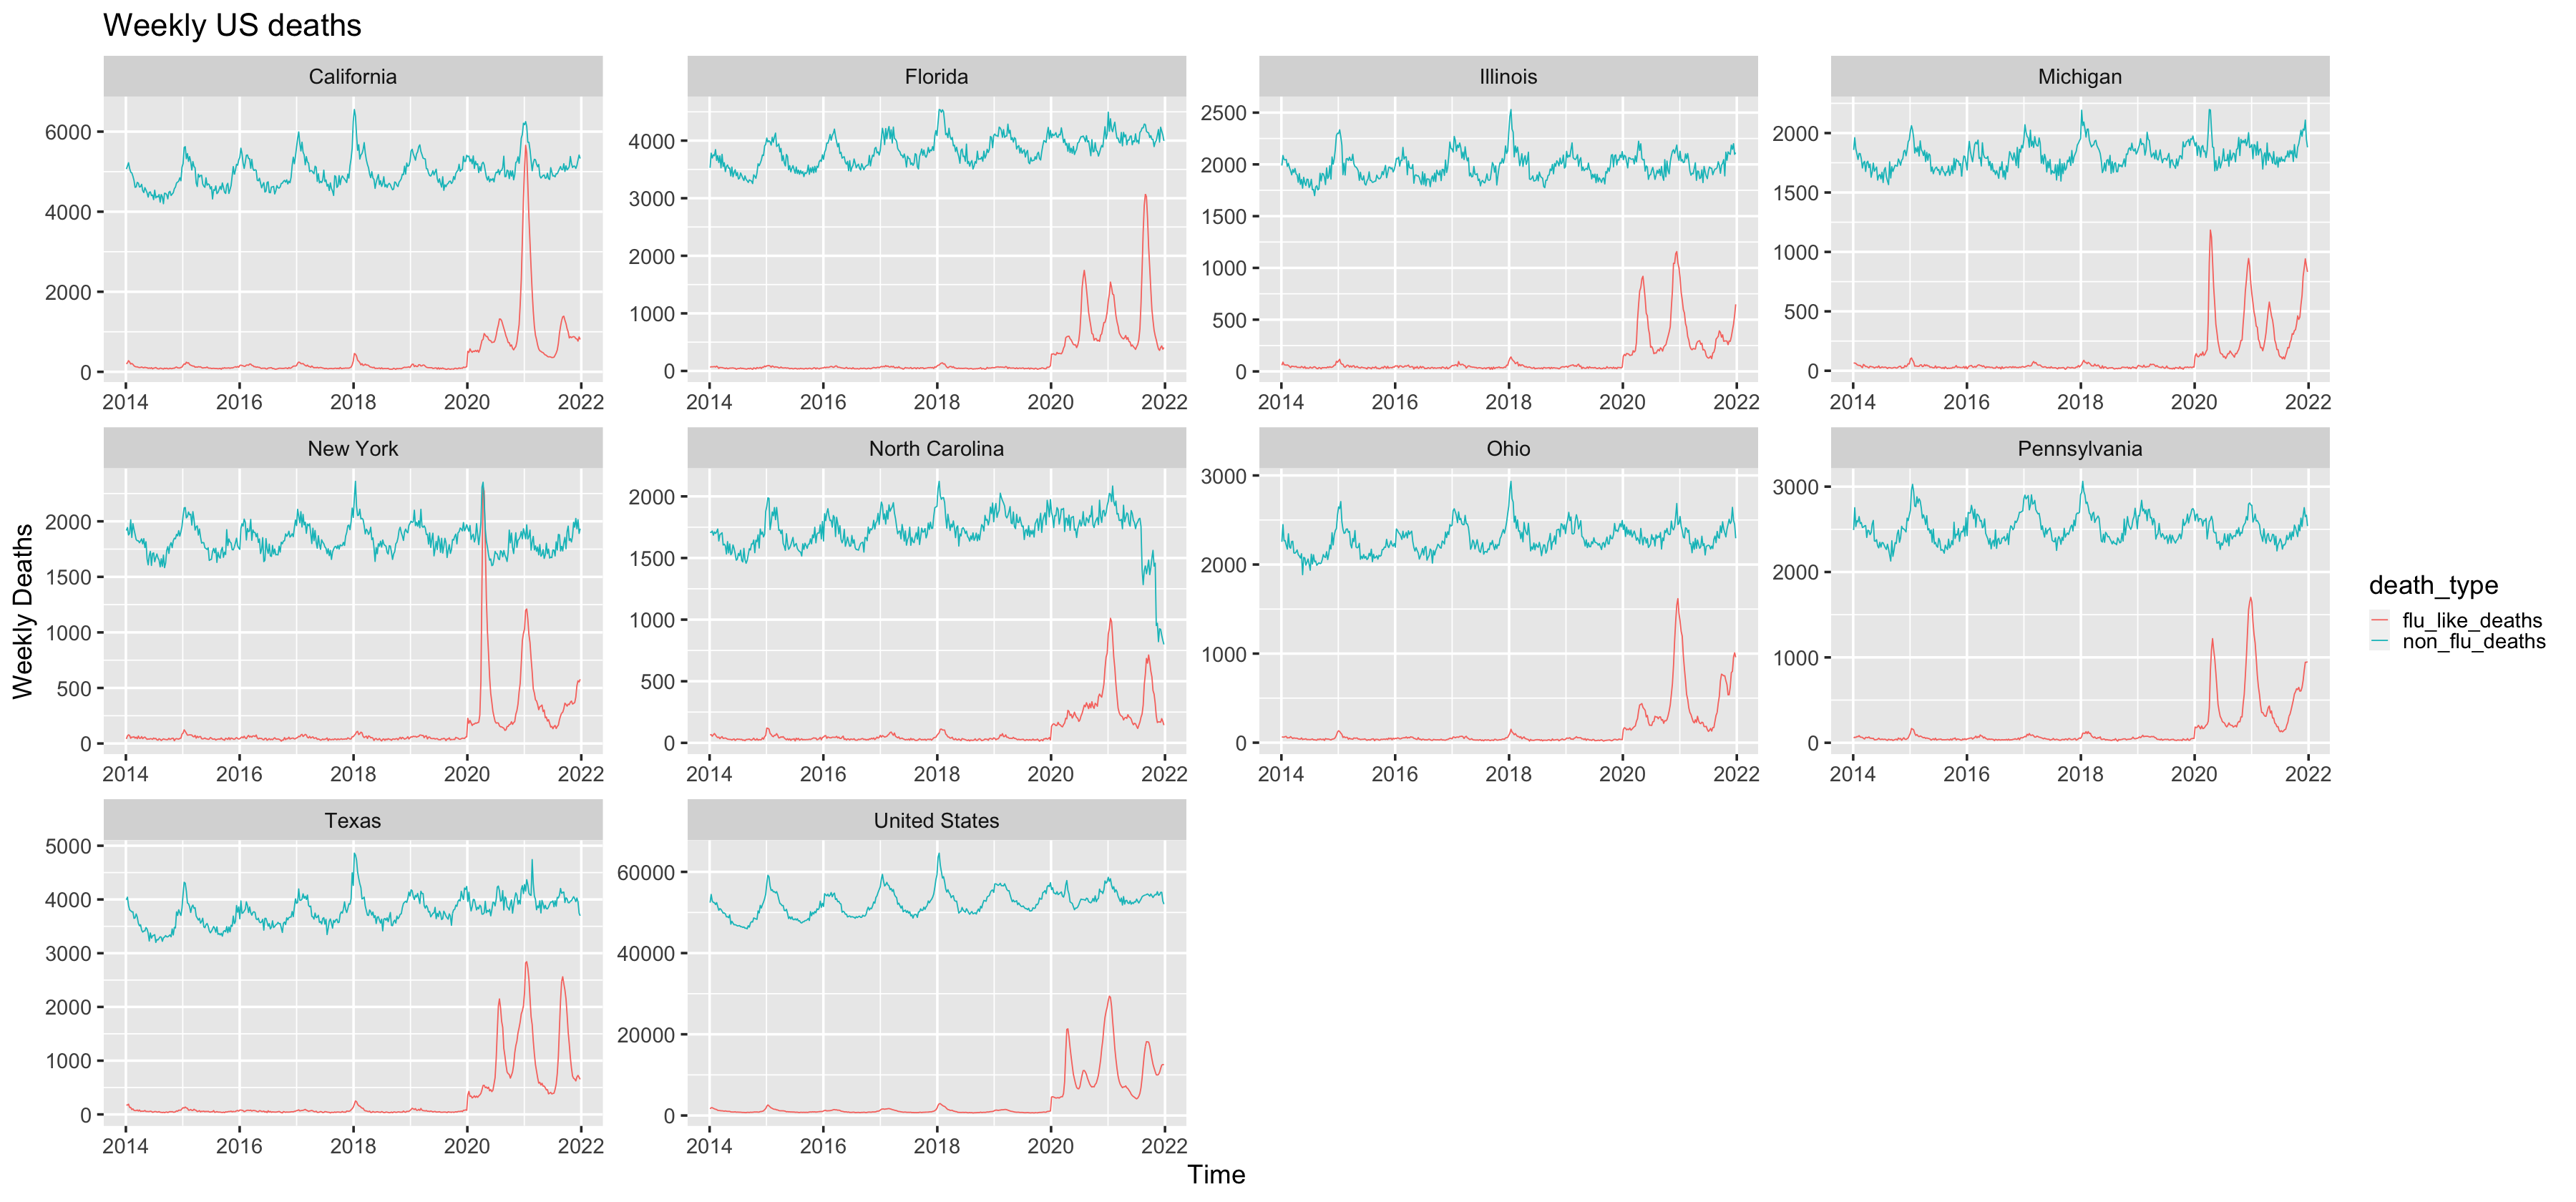

In [154]:
# Plot flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("non_flu_deaths", "flu_like_deaths"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% largest_ten,], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

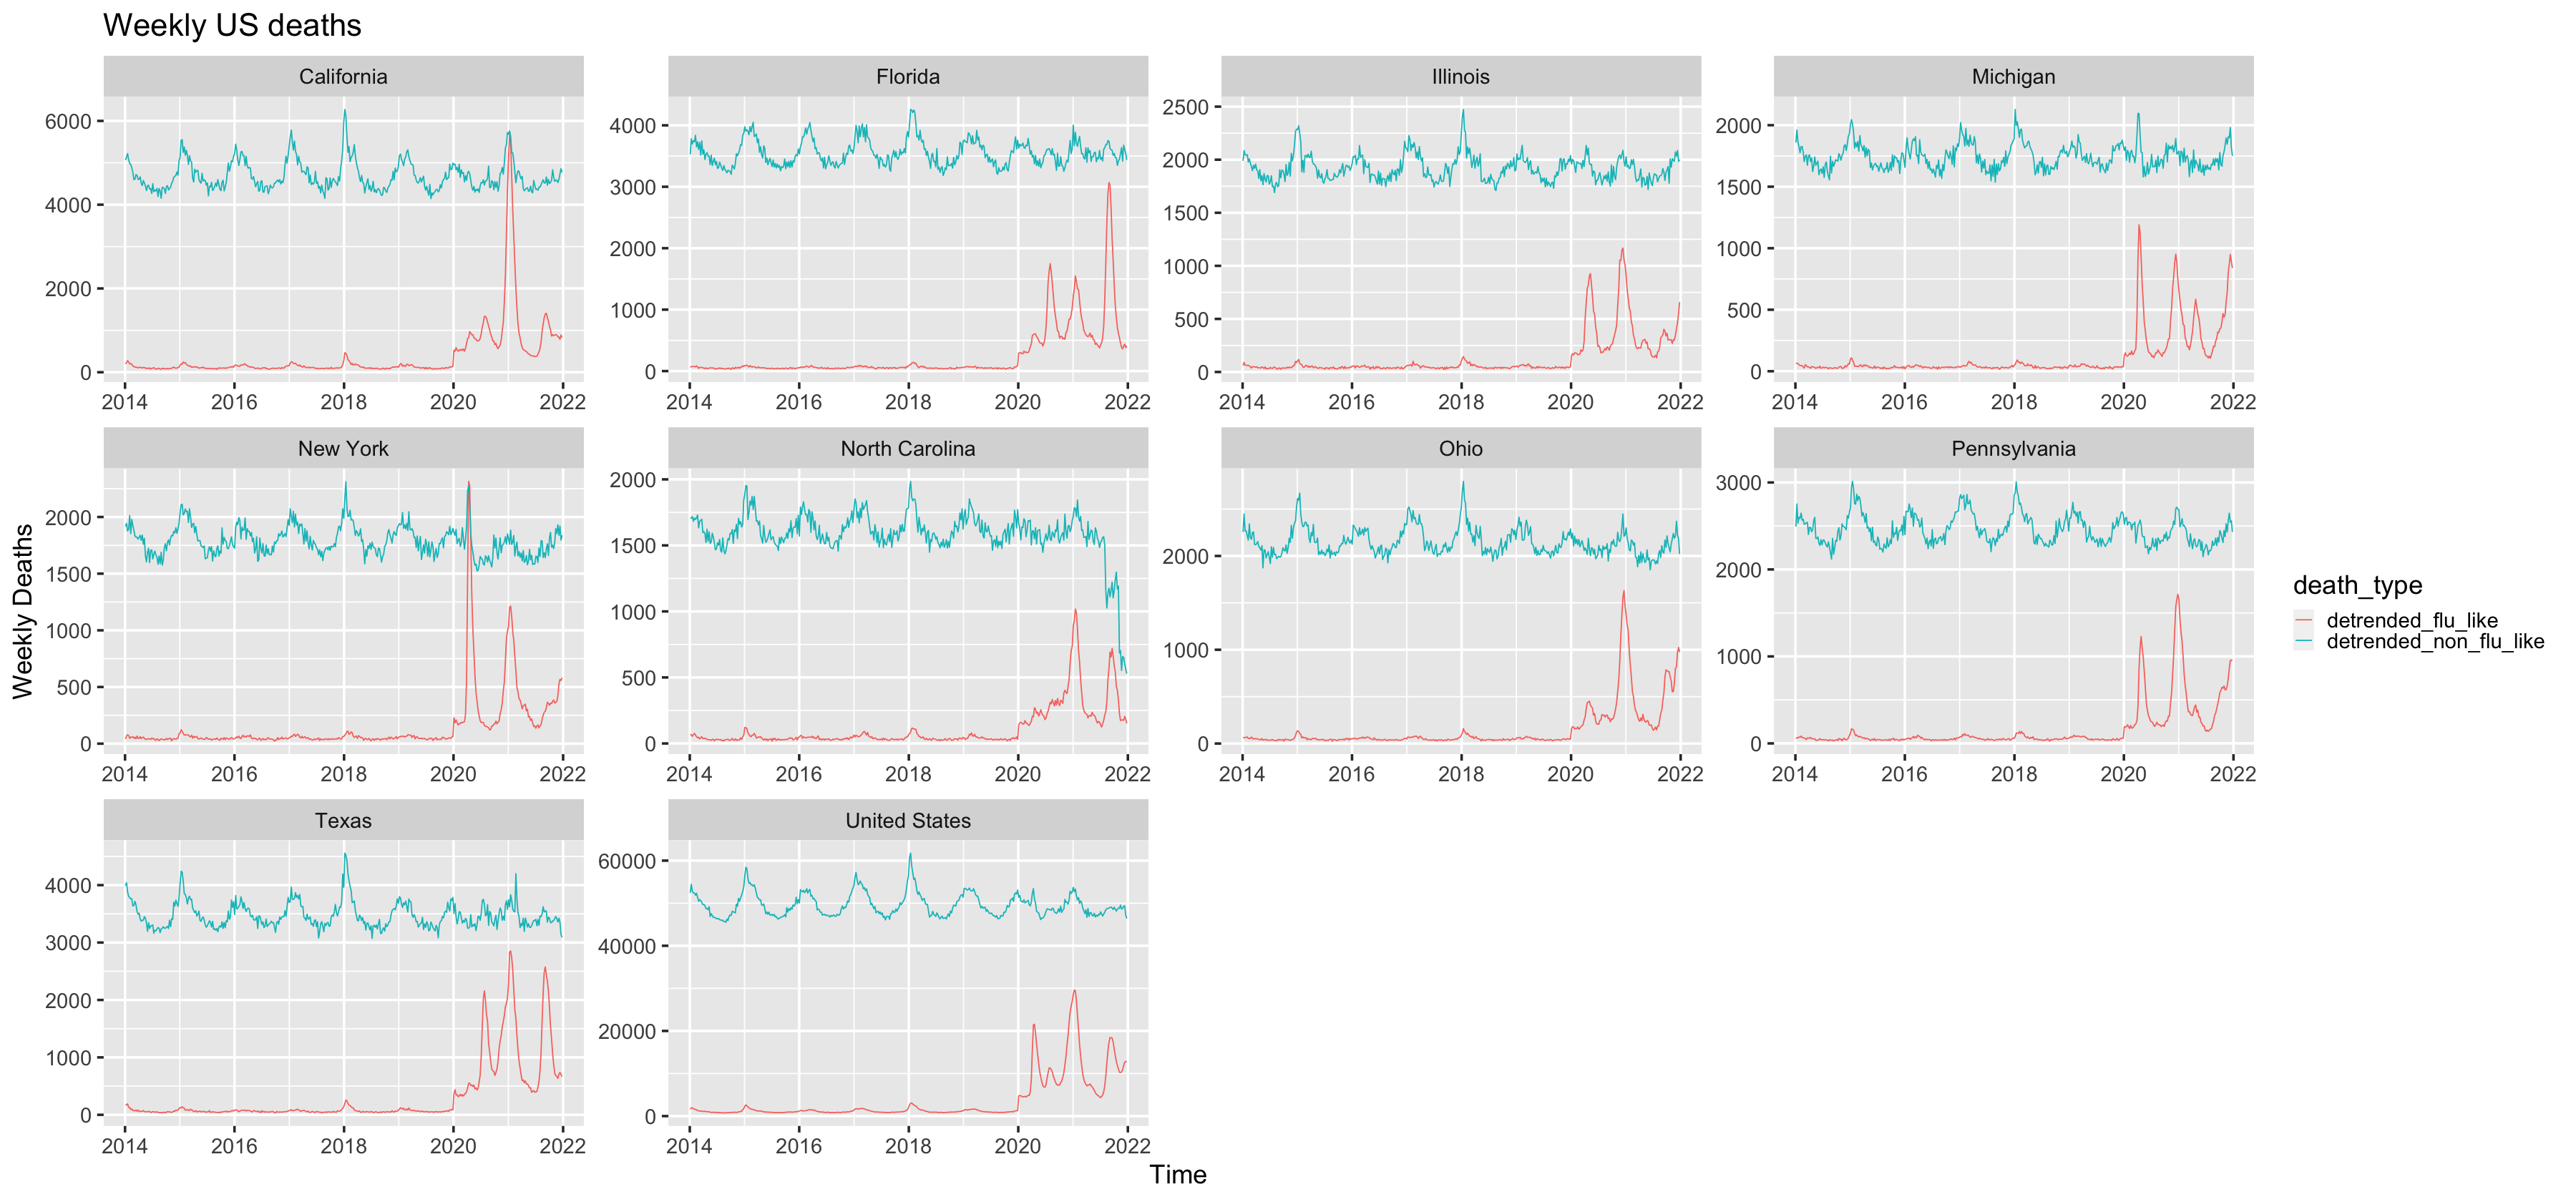

In [155]:
# Plot detrended flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("detrended_non_flu_like", "detrended_flu_like"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% largest_ten,], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [156]:
# A few things to note
# 1. Each state has a different deviation from pre-2020 non-flu deaths -> different diagnoses statewide
# 2. There is a discrete jump up in covid deaths Jan 2020, and a corresponding jump down in non-flu deaths

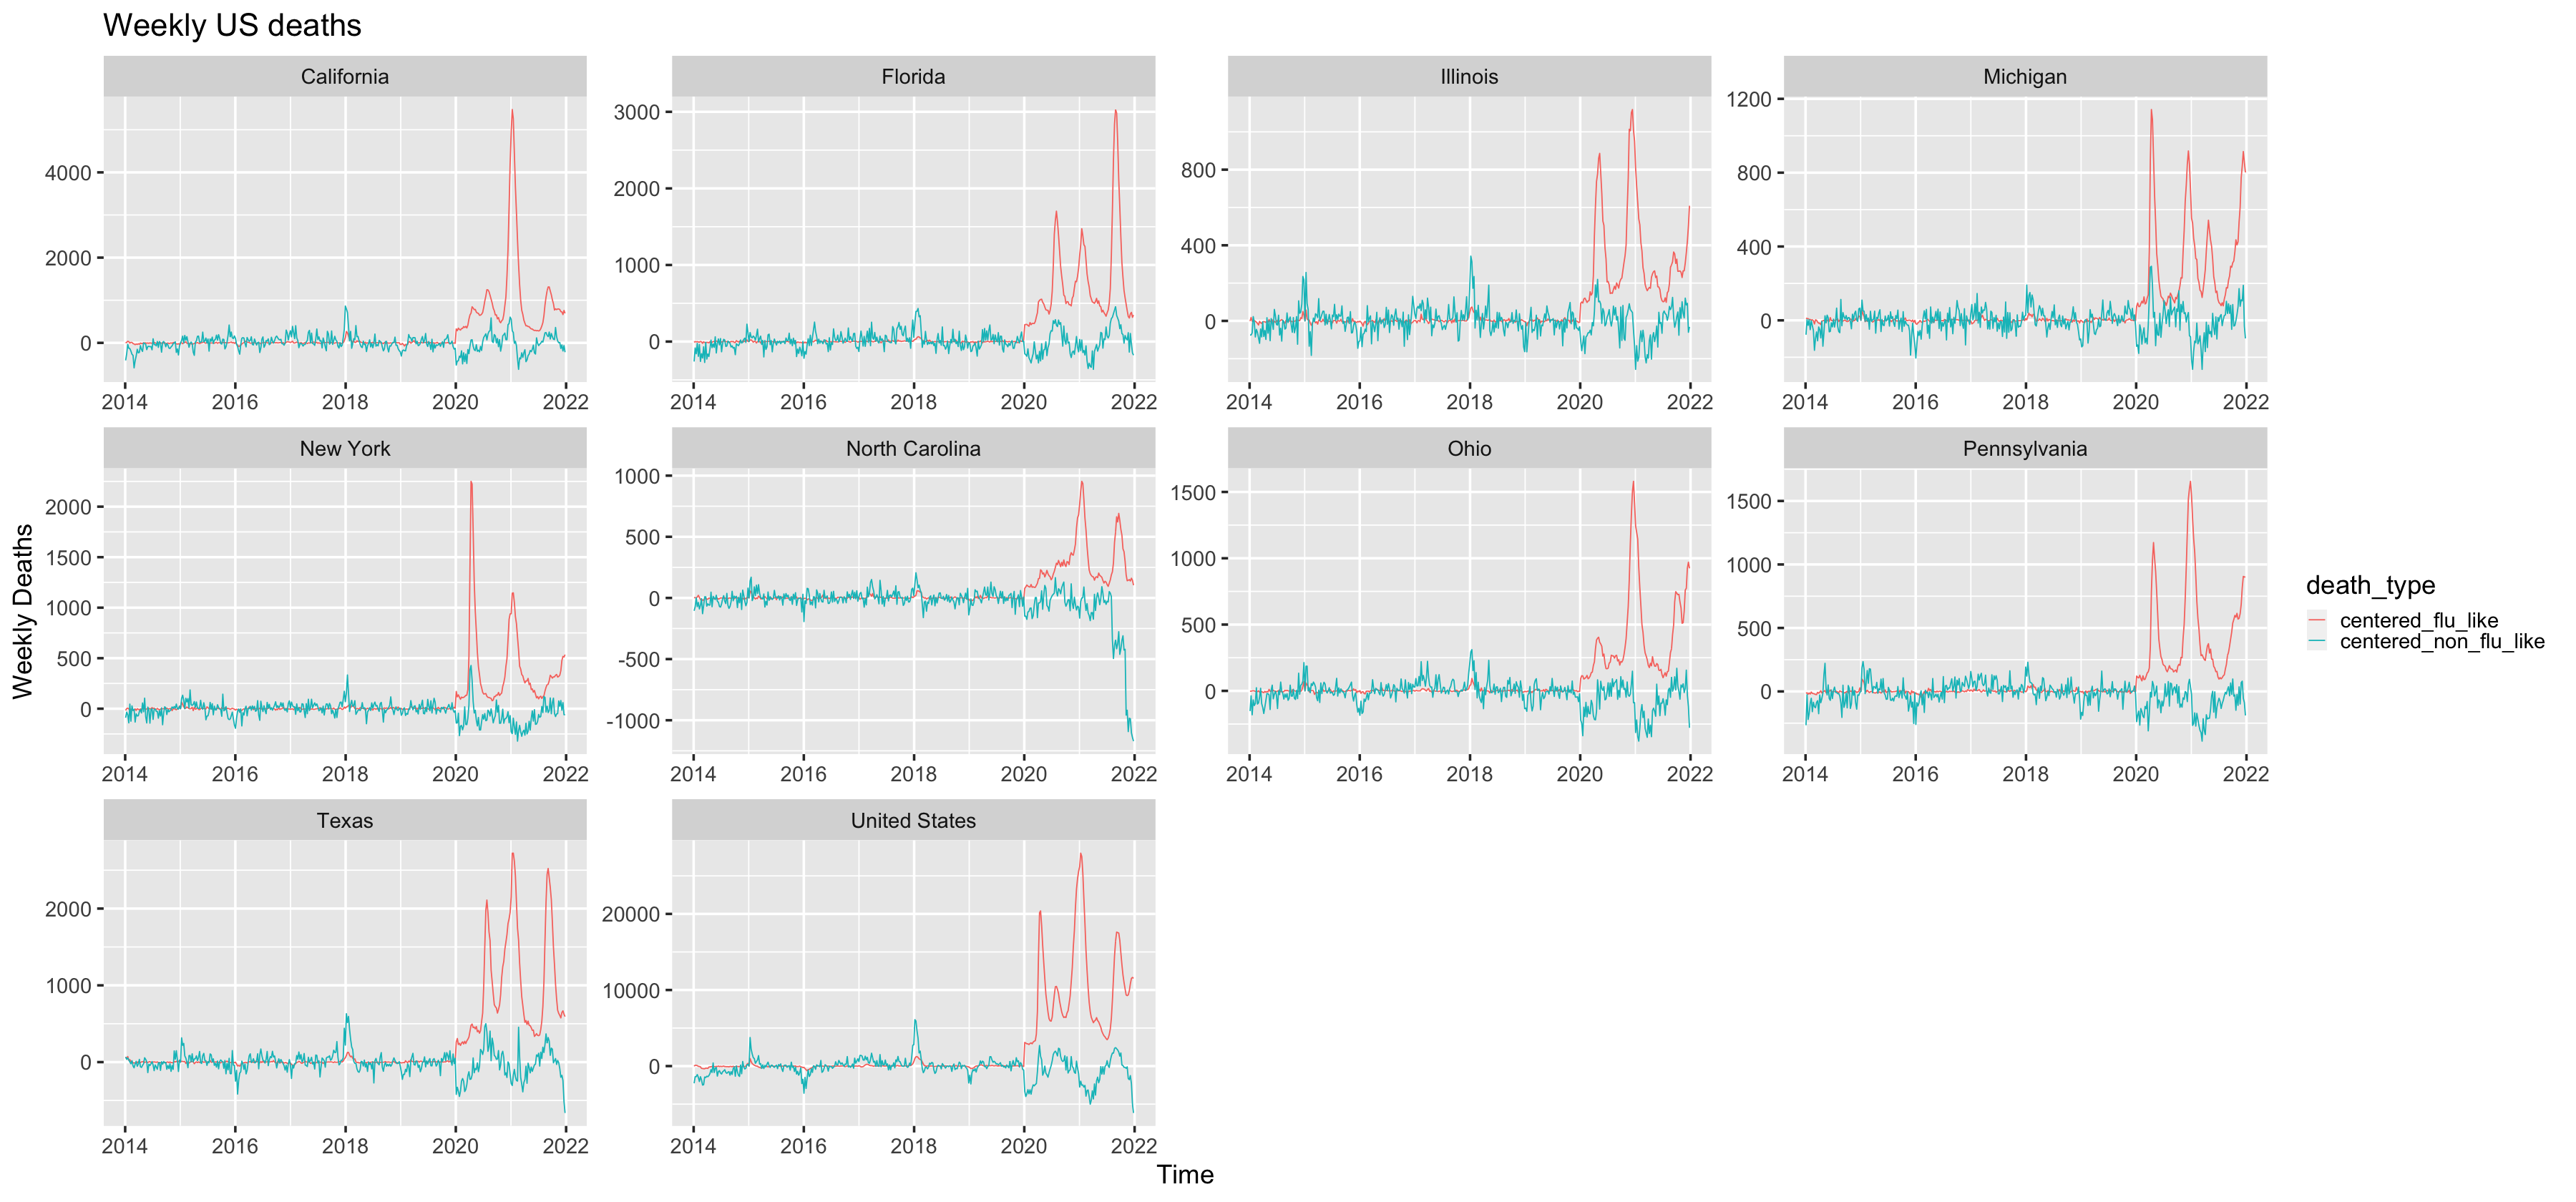

In [157]:
# Plot centered flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("centered_non_flu_like", "centered_flu_like"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% largest_ten,], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [1]:
undercounted = sum(state_centered[year(state_centered$Week.Ending.Date) > 2019 & state_centered$State == "United States",]$centered_non_flu_like)
sprintf("There are %d non-flu deaths less than in previous years.", abs(round(undercounted)))

ERROR: Error in eval(expr, envir, enclos): object 'state_centered' not found
